In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from utils.make_pairs import make_pairs

## Prepare Data For Siamese Network

Load Data and Labels

In [11]:
train_data_dir = r'C:\Users\jands\Market-1501-v15.09.15\bounding_box_train'
val_data_dir = r'C:\Users\jands\Market-1501-v15.09.15\bounding_box_val'

file_paths_train = tf.data.Dataset.list_files(train_data_dir + '/*.jpg')
file_paths_val = tf.data.Dataset.list_files(val_data_dir + '/*.jpg')

# Define the function to extract the label from the file name
# works for my specific directory path...
def extract_label(file_path):
    label = tf.strings.split(file_path, '_')
    label = tf.strings.split(label, '\\')
    return int(label[2][1])

def read_and_decode(file_path):
    label = extract_label(file_path)
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

print("[INFO] loading data...")

dataset_train = [read_and_decode(file) for file in file_paths_train]
dataset_val = [read_and_decode(file) for file in file_paths_val]

Visualize Training Data

IMAGE SHAPE:  (128, 64, 3)


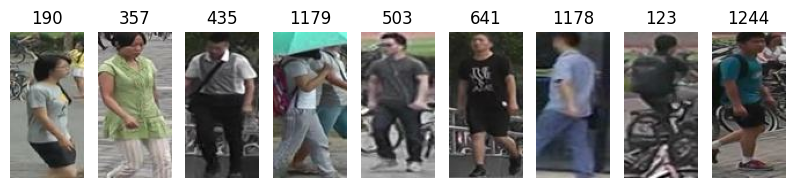

In [12]:
plt.figure(figsize=(10, 10))
subplot_pos = 1

for image, label in dataset_train[:9]:
  ax = plt.subplot(1, 9, subplot_pos)
  subplot_pos += 1
  plt.imshow(image)
  plt.title(label)
  plt.axis("off")

print("IMAGE SHAPE: ", image.shape)

In [13]:
labels = [label for image, label in dataset_train]
unique_labels = np.unique(np.array(labels))

idxs = [np.where(labels == unique_label)[0] for unique_label in unique_labels]

for unique_label in unique_labels:
    idxs = np.where(labels == unique_label)[0]
    print(f"{unique_label} => {len(idxs)} : {idxs}")

2 => 46 : [ 1320  1359  1926  2351  2415  2826  3035  3066  3126  3188  3481  3716
  3721  3772  3854  4201  4297  4311  4719  4894  4962  5097  5196  5273
  6045  6543  6756  6805  7436  7543  7705  7919  8497  8501  8709  8954
  9183 10130 10373 10799 11104 12316 12468 12748 12750 12757]
7 => 7 : [ 3547  3786  4394  6392  7735 12234 12779]
10 => 11 : [ 4616  4990  6133  6891 10129 10507 10655 10685 11196 11357 11399]
11 => 15 : [  906  1639  2806  3093  3096  3993  4815  7317  9957 11242 11408 11754
 11845 12404 12907]
12 => 6 : [ 2514  8663  9318  9462  9927 11760]
20 => 6 : [ 1432  1443  2124  4656  4682 10833]
22 => 59 : [  268   510   714   800   955  1417  1504  1516  1555  1743  1867  1891
  2120  2539  2713  2733  2886  3099  3272  3291  3324  3567  3708  4487
  4510  4857  5153  5545  5873  6460  7218  7555  7934  8097  8559  8651
  8724  9233  9260  9314  9361  9467 10137 10292 10785 10830 10866 11298
 11331 11517 11616 11781 11883 12036 12131 12204 12267 12588 12711]
23 => 

Make Pairs

In [14]:
train_pair_x, train_pair_y = make_pairs(dataset_train)
val_pair_x, val_pair_y = make_pairs(dataset_val)

c:\Users\jands\Project_Shaman\py_3_9_venv\lib\site-packages\matplotlib\text.py:1242: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


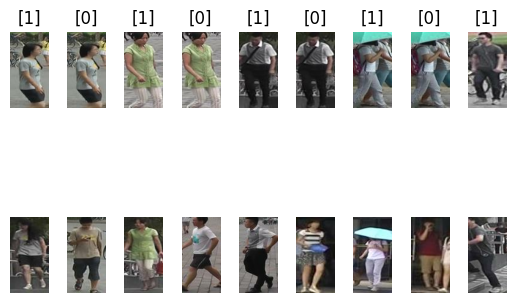

In [15]:
fig, axes = plt.subplots(2, 9)
plt.subplots_adjust(wspace=0.5, hspace=0)
j = 0

for img_1, img_2 in train_pair_x[:9]:
  axes[0, j].imshow(img_1)
  axes[1, j].imshow(img_2)
  axes[0, j].set_title(train_pair_y[j])
  axes[0, j].set_axis_off()
  axes[1, j].set_axis_off()
  j += 1

## Creating Siamese Network

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from utils.euclidian_distance import euclidean_distance

Choose a pretrained model

In [17]:
# the image size for all the images in The Market Dataset is 128x64
IMG_SHAPE = (128, 64, 3)

# Create the base model from the pre-trained model MobileNet V2
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
feature_extractor.trainable = False

In [ ]:
feature_extractor.summary()

Configure Siamese Network

In [19]:
print("[INFO] building model...")
img_1 = Input(shape=IMG_SHAPE)
img_2 = Input(shape=IMG_SHAPE)

features_1 = feature_extractor(img_1)
features_2 = feature_extractor(img_2)
distance = Lambda(euclidean_distance)([features_1, features_2])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[img_1, img_2], outputs=outputs)   

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 64, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 input_4 (InputLayer)           [(None, 128, 64, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 4, 2, 1280)  2257984     ['input_3[0][0]',                
 al)                                                              'input_4[0][0]']            

## Training Siamese Network

In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

# compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy"])
# train the model
print("[INFO] training model...")
history = model.fit(
	[train_pair_x[:, 0], train_pair_x[:, 1]], train_pair_y[:],
	validation_data=([val_pair_x[:, 0], val_pair_x[:, 1]], val_pair_y[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS)